In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from copy import deepcopy

import scipy
from scipy import special as s
import pandas as pd
import numpy
import math
from time import time

/Users/karlhajjar/Documents/projects/deep-wide-resnets/env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
cwd = os.getcwd()
NOTEBOOK_DIR = os.path.dirname(cwd+'/')
ROOT = os.path.dirname(NOTEBOOK_DIR)

import sys
sys.path.append(ROOT)

In [5]:
from utils.plot import *
from utils.tools import *
from utils.nn import TARGET_FUNCS_DICT, LOSS_DICT
from networks.muP_resnet import MuPResNet

# Constants

In [6]:
INPUT_DIM = 64 #30
WIDTH = 256 #512 #512 # 512 #40 # 256
#D_MODEL = 128
N_RES = 1000 #1000
BIAS = False
ALPHA = 1.0
SCALE = 1.0
ACTIVATION = 'relu'

SEED = 42
N_SAMPLES = 50 #100
N_TRIALS = 10 #10

In [7]:
FIGURES_DIR = os.path.join(ROOT, 'figures/init/')
create_dir(FIGURES_DIR)

In [8]:
set_random_seeds(SEED)

# First forward-backward

In [9]:
(start, num) = (10, 10)
betas = [0.25, 0.5, 1.0] #[0., 0.25, 0.5, 1.0]
all_x = torch.randn(size=(N_TRIALS, N_SAMPLES, INPUT_DIM))
all_y = torch.randn(size=(N_TRIALS, N_SAMPLES, 1))
n_res_grid = np.linspace(start=start, stop=N_RES, num=num, dtype=int)

ratios = dict()
direct_ratios = dict()
grad_ratios = dict()
direct_grad_ratios = dict()

s = time()
for beta in betas:
    ratios_ = {n_res: [] for n_res in n_res_grid}
    direct_ratios_ = {n_res: [] for n_res in n_res_grid}
    grad_ratios_ = {n_res: [] for n_res in n_res_grid}
    direct_grad_ratios_ = {n_res: [] for n_res in n_res_grid}
    
    for n_res in n_res_grid:
        for i in range(N_TRIALS):
            alpha = n_res**(-beta)
            net = MuPResNet(input_dim=INPUT_DIM, width=WIDTH, activation=ACTIVATION, bias=BIAS, alpha=alpha, 
                            n_res=n_res)
            x = all_x[i, :, :]
            y = all_y[i, :, :]
            
            h_0 = np.sqrt(net.d_model) * net.input_layer(x)  # muP scaling for the first layer
            h_0.retain_grad()

            h_L = net.residual_layers(h_0)
            h_L.retain_grad()

            y_hat = net.output_layer(h_L) / np.sqrt(net.d_model)  # muP scaling for the last layer
            loss = 0.5 * torch.mean((y_hat - y)**2)
            loss.backward()  # gradient computation
            
            # forward norms
            h_0_norm = torch.norm(h_0, dim=1, p=2)
            ratios_[n_res].append(torch.mean((torch.norm(h_L-h_0, dim=1,p=2)) /
                                              h_0_norm).detach().item())
            direct_ratios_[n_res].append(torch.mean((torch.norm(h_L, dim=1,p=2)) / 
                                                    h_0_norm).detach().item())
            
            # backward (grads) norms
            dh_L_norm = torch.norm(h_L.grad, dim=1, p=2)
            grad_ratios_[n_res].append(torch.mean((torch.norm(h_0.grad - h_L.grad, dim=1,p=2)) /
                                       dh_L_norm).detach().item())
            direct_grad_ratios_[n_res].append(torch.mean((torch.norm(h_0.grad, dim=1,p=2)) / 
                                                         dh_L_norm).detach().item())

    ratios[beta] = ratios_
    direct_ratios[beta] = direct_ratios_
    grad_ratios[beta] = grad_ratios_
    direct_grad_ratios[beta] = direct_grad_ratios_
        
e = time()
print('Time for L={:,} and N_TRIALS={:,} : {:.2f} minutes'.format(N_RES, N_TRIALS, (e - s)/60))

Time for L=1,000 and N_TRIALS=10 : 9.39 minutes


# Forward plots

## 1. Difference ratios

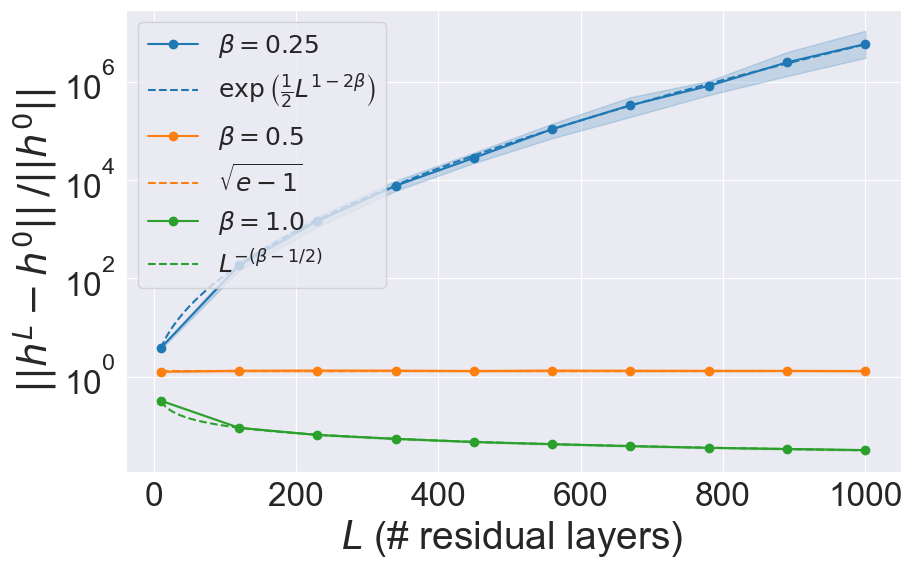

In [10]:
plt.figure(figsize=(10, 6))
plt.yscale('log')
marker = 'o'
#plt.xscale('log')
colors = sns.color_palette()

for i, key in enumerate(ratios.keys()):
    data = pd.DataFrame(ratios[key])
    mins = data.min(axis=0).values
    maxs = data.max(axis=0).values
    means = data.mean(axis=0).values
    
    delta = 1 - 2 * key

    plt.plot(data.columns.values, means, marker=marker, label='$\\beta = {}$'.format(key), c=colors[i])
    plt.fill_between(data.columns.values, mins, maxs, alpha=0.2, color=colors[i])

    if delta > 0:
        plt.plot(np.arange(start, N_RES+1), np.exp(((np.arange(start, N_RES+1) ** delta) -0.5)/2), 
                 label='$\\exp \\left(\\frac{1}{2} L^{1 -2\\beta} \\right)$', c=colors[i], linestyle='dashed')
    elif delta < 0:
        plt.plot(np.arange(start, N_RES+1), np.arange(start, N_RES+1)  ** (delta/2), 
                 label='$L^{-(\\beta - 1/2)}$', c=colors[i], linestyle='dashed')
    else:  # delta = 0
        plt.plot(np.arange(start, N_RES+1), len(np.arange(start, N_RES+1)) * [np.sqrt(np.exp(1) - 1)], 
                 label='$\\sqrt{e - 1}$', c=colors[i], linestyle='dashed')

plt.xlabel('$L$ (# residual layers) ', fontsize=28)
plt.ylabel('$||h^L - h^0|| \, / ||h^0||$', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
plt.savefig(os.path.join(FIGURES_DIR, 'ratio.png'), bbox_inches='tight')
plt.show()

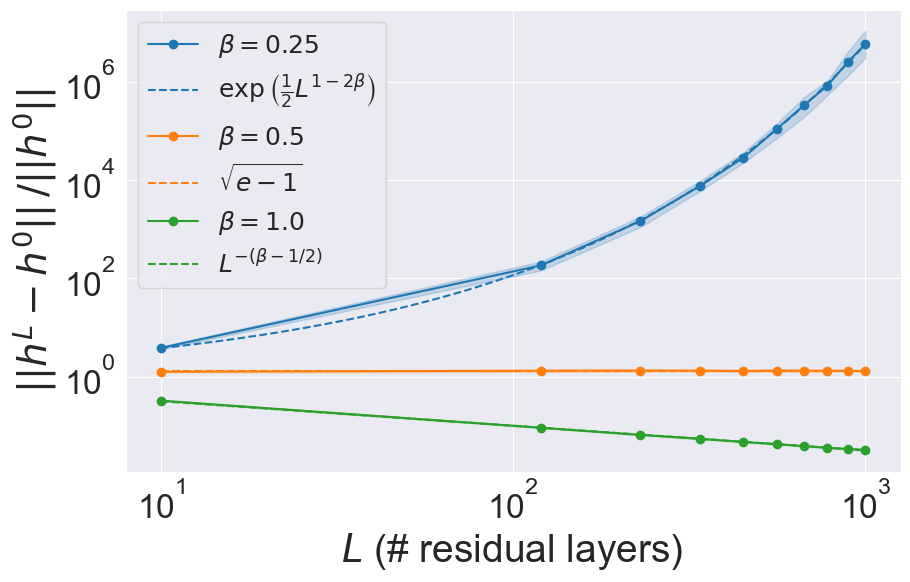

In [11]:
plt.figure(figsize=(10, 6))
plt.yscale('log')
marker = 'o'
plt.xscale('log')
colors = sns.color_palette()

for i, key in enumerate(ratios.keys()):
    data = pd.DataFrame(ratios[key])
    mins = data.min(axis=0).values
    maxs = data.max(axis=0).values
    means = data.mean(axis=0).values
    
    delta = 1 - 2 * key

    plt.plot(data.columns.values, means, marker=marker, label='$\\beta = {}$'.format(key), c=colors[i])
    plt.fill_between(data.columns.values, mins, maxs, alpha=0.2, color=colors[i])

    if delta > 0:
        plt.plot(np.arange(start, N_RES+1), np.exp(((np.arange(start, N_RES+1) ** delta) -0.5)/2), 
                 label='$\\exp \\left(\\frac{1}{2} L^{1 -2\\beta} \\right)$', c=colors[i], linestyle='dashed')
    elif delta < 0:
        plt.plot(np.arange(start, N_RES+1), np.arange(start, N_RES+1)  ** (delta/2), 
                 label='$L^{-(\\beta - 1/2)}$', c=colors[i], linestyle='dashed')
    else:  # delta = 0
        plt.plot(np.arange(start, N_RES+1), len(np.arange(start, N_RES+1)) * [np.sqrt(np.exp(1) - 1)], 
                 label='$\\sqrt{e - 1}$', c=colors[i], linestyle='dashed')

plt.xlabel('$L$ (# residual layers) ', fontsize=28)
plt.ylabel('$||h^L - h^0|| \, / ||h^0||$', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
plt.savefig(os.path.join(FIGURES_DIR, 'ratio_log-log.png'), bbox_inches='tight')
plt.show()

## 2. Direct ratios

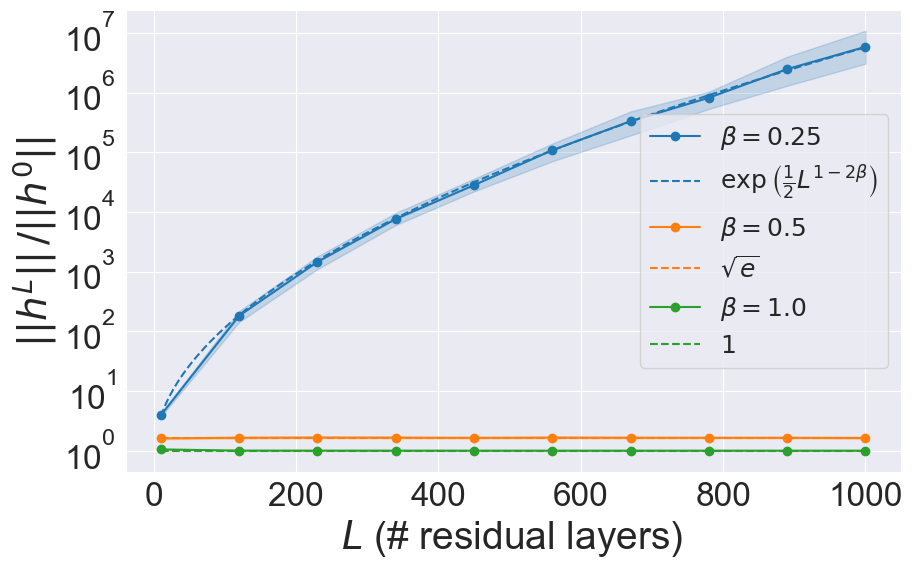

In [12]:
plt.figure(figsize=(10, 6))
plt.yscale('log')
marker = 'o'
#plt.xscale('log')
colors = sns.color_palette()

for i, key in enumerate(direct_ratios.keys()):
    data = pd.DataFrame(direct_ratios[key])
    mins = data.min(axis=0).values
    maxs = data.max(axis=0).values
    means = data.mean(axis=0).values
    
    delta = 1 - 2 * key

    plt.plot(data.columns.values, means, marker=marker, label='$\\beta = {}$'.format(key), c=colors[i])
    plt.fill_between(data.columns.values, mins, maxs, alpha=0.2, color=colors[i])

    if delta > 0:
        plt.plot(np.arange(start, N_RES+1), np.exp(((np.arange(start, N_RES+1) ** delta) -0.5)/2), 
                 label='$\\exp \\left(\\frac{1}{2} L^{1 -2\\beta} \\right)$', c=colors[i], linestyle='dashed')
    elif delta < 0:
        plt.plot(np.arange(start, N_RES+1), np.ones_like(np.arange(start, N_RES+1)), 
                 label='$1$', c=colors[i], linestyle='dashed')
    else:  # delta = 0
        plt.plot(np.arange(start, N_RES+1), np.exp(np.ones_like(np.arange(start, N_RES+1)) / 2), 
                 label='$\\sqrt{e}$', c=colors[i], linestyle='dashed')

plt.xlabel('$L$ (# residual layers) ', fontsize=28)
plt.ylabel('$||h^L|| \, / ||h^0||$', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
plt.savefig(os.path.join(FIGURES_DIR, 'ratio.png'), bbox_inches='tight')
plt.show()

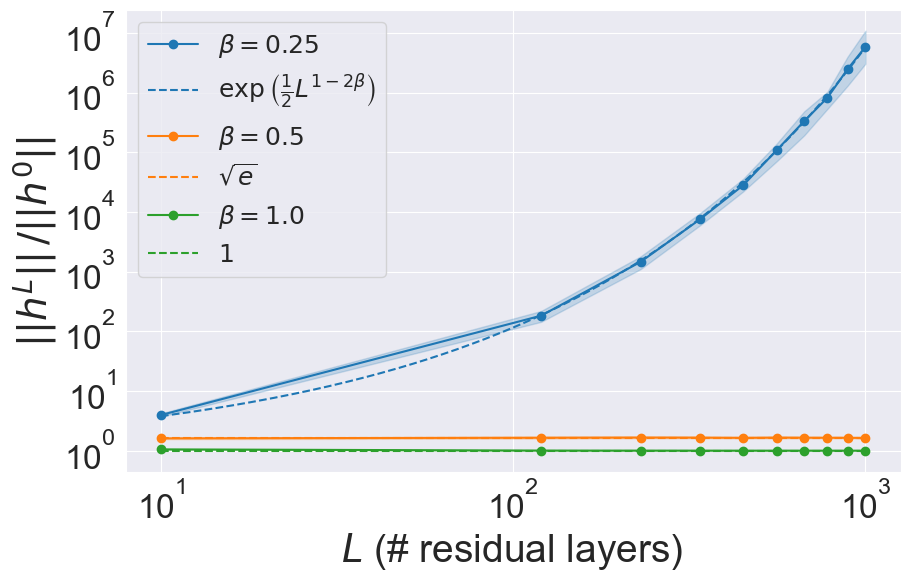

In [13]:
plt.figure(figsize=(10, 6))
plt.yscale('log')
marker = 'o'
plt.xscale('log')
colors = sns.color_palette()

for i, key in enumerate(direct_ratios.keys()):
    data = pd.DataFrame(direct_ratios[key])
    mins = data.min(axis=0).values
    maxs = data.max(axis=0).values
    means = data.mean(axis=0).values
    
    delta = 1 - 2 * key

    plt.plot(data.columns.values, means, marker=marker, label='$\\beta = {}$'.format(key), c=colors[i])
    plt.fill_between(data.columns.values, mins, maxs, alpha=0.2, color=colors[i])

    if delta > 0:
        plt.plot(np.arange(start, N_RES+1), np.exp(((np.arange(start, N_RES+1) ** delta) -0.5)/2), 
                 label='$\\exp \\left(\\frac{1}{2} L^{1 -2\\beta} \\right)$', c=colors[i], linestyle='dashed')
    elif delta < 0:
        plt.plot(np.arange(start, N_RES+1), np.ones_like(np.arange(start, N_RES+1)), 
                 label='$1$', c=colors[i], linestyle='dashed')
    else:  # delta = 0
        plt.plot(np.arange(start, N_RES+1), np.exp(np.ones_like(np.arange(start, N_RES+1)) / 2), 
                 label='$\\sqrt{e}$', c=colors[i], linestyle='dashed')

plt.xlabel('$L$ (# residual layers) ', fontsize=28)
plt.ylabel('$||h^L|| \, / ||h^0||$', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
plt.savefig(os.path.join(FIGURES_DIR, 'ratio.png'), bbox_inches='tight')
plt.show()

# Backward plots

## 1. Difference ratios

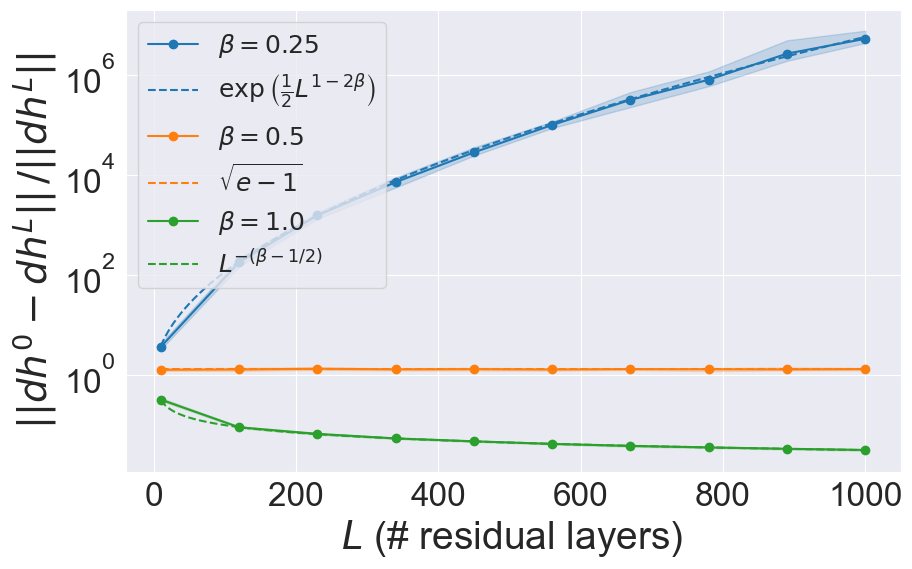

In [14]:
plt.figure(figsize=(10, 6))
plt.yscale('log')
marker = 'o'
#plt.xscale('log')
colors = sns.color_palette()

for i, key in enumerate(grad_ratios.keys()):
    data = pd.DataFrame(grad_ratios[key])
    mins = data.min(axis=0).values
    maxs = data.max(axis=0).values
    means = data.mean(axis=0).values
    
    delta = 1 - 2 * key

    plt.plot(data.columns.values, means, marker=marker, label='$\\beta = {}$'.format(key), c=colors[i])
    plt.fill_between(data.columns.values, mins, maxs, alpha=0.2, color=colors[i])

    if delta > 0:
        plt.plot(np.arange(start, N_RES+1), np.exp(((np.arange(start, N_RES+1) ** delta) -0.5)/2), 
                 label='$\\exp \\left(\\frac{1}{2} L^{1 -2\\beta} \\right)$', c=colors[i], linestyle='dashed')
    elif delta < 0:
        plt.plot(np.arange(start, N_RES+1), np.arange(start, N_RES+1)  ** (delta/2), 
                 label='$L^{-(\\beta - 1/2)}$', c=colors[i], linestyle='dashed')
    else:  # delta = 0
        plt.plot(np.arange(start, N_RES+1), len(np.arange(start, N_RES+1)) * [np.sqrt(np.exp(1) - 1)], 
                 label='$\\sqrt{e - 1}$', c=colors[i], linestyle='dashed')

plt.xlabel('$L$ (# residual layers) ', fontsize=28)
plt.ylabel('$||dh^0 - dh^L|| \, / ||dh^L||$', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
plt.savefig(os.path.join(FIGURES_DIR, 'ratio.png'), bbox_inches='tight')
plt.show()

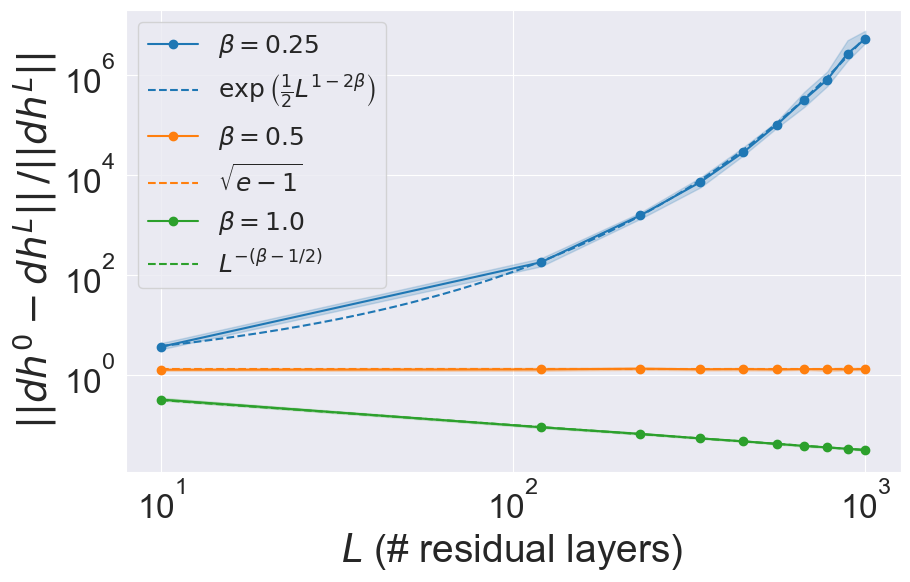

In [15]:
plt.figure(figsize=(10, 6))
plt.yscale('log')
marker = 'o'
plt.xscale('log')
colors = sns.color_palette()

for i, key in enumerate(grad_ratios.keys()):
    data = pd.DataFrame(grad_ratios[key])
    mins = data.min(axis=0).values
    maxs = data.max(axis=0).values
    means = data.mean(axis=0).values
    
    delta = 1 - 2 * key

    plt.plot(data.columns.values, means, marker=marker, label='$\\beta = {}$'.format(key), c=colors[i])
    plt.fill_between(data.columns.values, mins, maxs, alpha=0.2, color=colors[i])

    if delta > 0:
        plt.plot(np.arange(start, N_RES+1), np.exp(((np.arange(start, N_RES+1) ** delta) -0.5)/2), 
                 label='$\\exp \\left(\\frac{1}{2} L^{1 -2\\beta} \\right)$', c=colors[i], linestyle='dashed')
    elif delta < 0:
        plt.plot(np.arange(start, N_RES+1), np.arange(start, N_RES+1)  ** (delta/2), 
                 label='$L^{-(\\beta - 1/2)}$', c=colors[i], linestyle='dashed')
    else:  # delta = 0
        plt.plot(np.arange(start, N_RES+1), len(np.arange(start, N_RES+1)) * [np.sqrt(np.exp(1) - 1)], 
                 label='$\\sqrt{e - 1}$', c=colors[i], linestyle='dashed')

plt.xlabel('$L$ (# residual layers) ', fontsize=28)
plt.ylabel('$||dh^0 - dh^L|| \, / ||dh^L||$', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
plt.savefig(os.path.join(FIGURES_DIR, 'ratio.png'), bbox_inches='tight')
plt.show()

## 2. Direct ratios

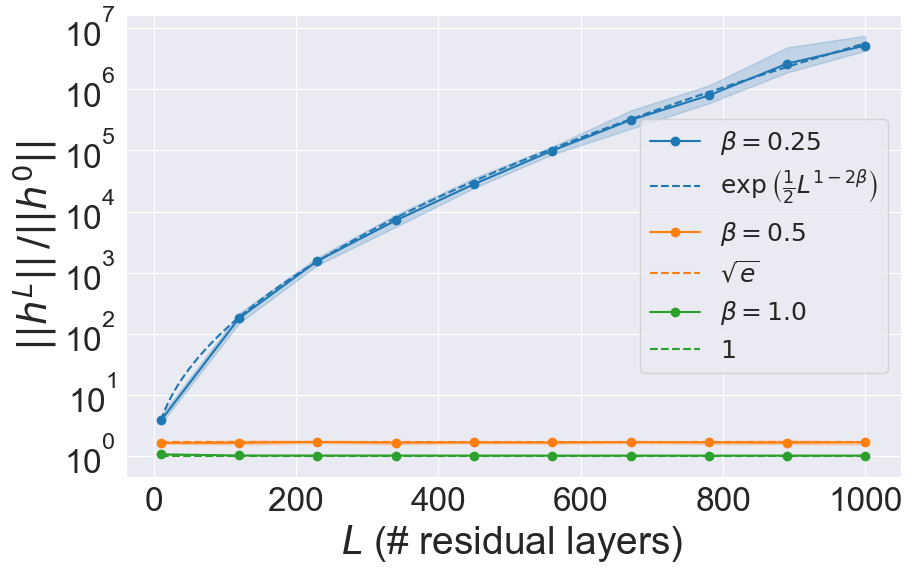

In [16]:
plt.figure(figsize=(10, 6))
plt.yscale('log')
marker = 'o'
#plt.xscale('log')
colors = sns.color_palette()

for i, key in enumerate(direct_grad_ratios.keys()):
    data = pd.DataFrame(direct_grad_ratios[key])
    mins = data.min(axis=0).values
    maxs = data.max(axis=0).values
    means = data.mean(axis=0).values
    
    delta = 1 - 2 * key

    plt.plot(data.columns.values, means, marker=marker, label='$\\beta = {}$'.format(key), c=colors[i])
    plt.fill_between(data.columns.values, mins, maxs, alpha=0.2, color=colors[i])

    if delta > 0:
        plt.plot(np.arange(start, N_RES+1), np.exp(((np.arange(start, N_RES+1) ** delta) -0.5)/2), 
                 label='$\\exp \\left(\\frac{1}{2} L^{1 -2\\beta} \\right)$', c=colors[i], linestyle='dashed')
    elif delta < 0:
        plt.plot(np.arange(start, N_RES+1), np.ones_like(np.arange(start, N_RES+1)), 
                 label='$1$', c=colors[i], linestyle='dashed')
    else:  # delta = 0
        plt.plot(np.arange(start, N_RES+1), np.exp(np.ones_like(np.arange(start, N_RES+1)) / 2), 
                 label='$\\sqrt{e}$', c=colors[i], linestyle='dashed')

plt.xlabel('$L$ (# residual layers) ', fontsize=28)
plt.ylabel('$||h^L|| \, / ||h^0||$', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
plt.savefig(os.path.join(FIGURES_DIR, 'ratio.png'), bbox_inches='tight')
plt.show()

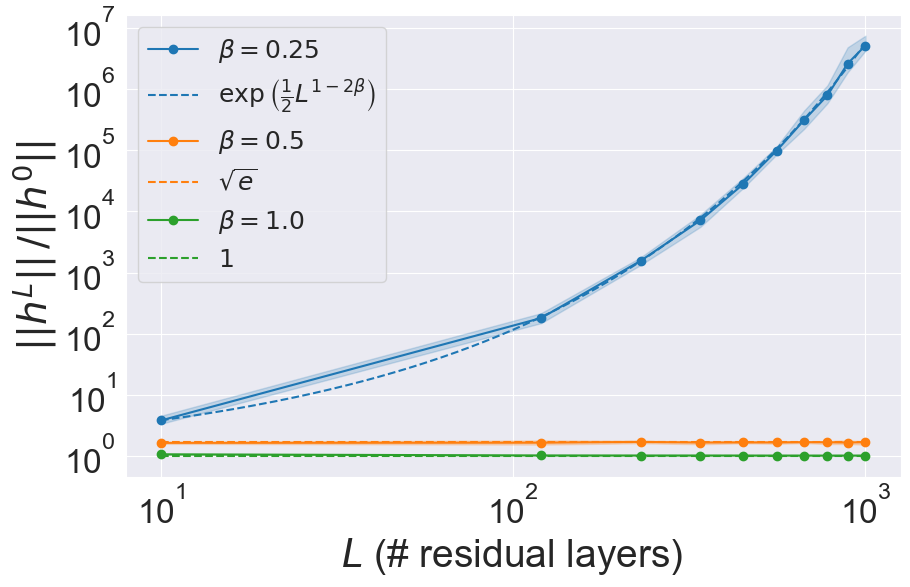

In [17]:
plt.figure(figsize=(10, 6))
plt.yscale('log')
marker = 'o'
plt.xscale('log')
colors = sns.color_palette()

for i, key in enumerate(direct_grad_ratios.keys()):
    data = pd.DataFrame(direct_grad_ratios[key])
    mins = data.min(axis=0).values
    maxs = data.max(axis=0).values
    means = data.mean(axis=0).values
    
    delta = 1 - 2 * key

    plt.plot(data.columns.values, means, marker=marker, label='$\\beta = {}$'.format(key), c=colors[i])
    plt.fill_between(data.columns.values, mins, maxs, alpha=0.2, color=colors[i])

    if delta > 0:
        plt.plot(np.arange(start, N_RES+1), np.exp(((np.arange(start, N_RES+1) ** delta) -0.5)/2), 
                 label='$\\exp \\left(\\frac{1}{2} L^{1 -2\\beta} \\right)$', c=colors[i], linestyle='dashed')
    elif delta < 0:
        plt.plot(np.arange(start, N_RES+1), np.ones_like(np.arange(start, N_RES+1)), 
                 label='$1$', c=colors[i], linestyle='dashed')
    else:  # delta = 0
        plt.plot(np.arange(start, N_RES+1), np.exp(np.ones_like(np.arange(start, N_RES+1)) / 2), 
                 label='$\\sqrt{e}$', c=colors[i], linestyle='dashed')

plt.xlabel('$L$ (# residual layers) ', fontsize=28)
plt.ylabel('$||h^L|| \, / ||h^0||$', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
plt.savefig(os.path.join(FIGURES_DIR, 'ratio.png'), bbox_inches='tight')
plt.show()